In [1]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import layers

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_graph(history):
    plt.plot(history.epoch, history.history['loss'], label='loss')
    plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
    plt.ylabel('%')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [3]:
LEARNING_RATE = 0.02
to_be_resized = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

In [4]:
df = pd.read_csv('cover_data.csv')
data = df.iloc[:,0:-1]
labels = df.iloc[:,-1:]

train_dt, test_dt, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=32)


std = ColumnTransformer([('standardize', StandardScaler(), to_be_resized)], remainder='passthrough')

In [5]:
scaled_train_dt = pd.DataFrame(std.fit_transform(train_dt))
scaled_test_dt = pd.DataFrame(std.transform(test_dt))
scaled_train_lb = train_labels - 1
scaled_test_lb = test_labels - 1

In [6]:
def create_model(l_rate, data):
    model = keras.Sequential()
    # Input
    model.add(layers.InputLayer(input_shape=(data.shape[1],)))
    # Hidden layers
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.25))
    # Hidden layers
    model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dropout(0.1))
    # Hidden layers
    # model.add(layers.Dense(14, activation='relu'))
    # Output
    model.add(layers.Dense(7, activation='softmax'))
    # Compile
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    # keras.optimizers.Adam(learning_rate=l_rate)
    return model

In [7]:
stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)

model = create_model(LEARNING_RATE, train_dt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7040      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 11,399
Trainable params: 11,399
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
409/409 [==============================] - 4s 6ms/step - loss: 0.7412 - accuracy: 0.7067 - val_loss: 0.5861 - val_accuracy: 0.7488
Epoch 2/100
409/409 [==============================] - 2s 5ms/step - loss: 0.5503 - accuracy: 0.7665 - val_loss: 0.5229 - val_accuracy: 0.7752
Epoch 3/100
409/409 [==============================] - 2s 5ms/step - loss: 0.5016 - accuracy: 0.7866 - val_loss: 0.4838 - val_accuracy: 0.7944
Epoch 4/100
409/409 [==============================] - 3s 6ms/step - loss: 0.4695 - accuracy: 0.8023 - val_loss: 0.4593 - val_accuracy: 0.8062
Epoch 5/100
409/409 [==============================] - 2s 6ms/step - loss: 0.4466 - accuracy: 0.8127 - val_loss: 0.4392 - val_accuracy: 0.8144
Epoch 6/100
409/409 [==============================] - 3s 6ms/step - loss: 0.4293 - accuracy: 0.8209 - val_loss: 0.4219 - val_accuracy: 0.8239
Epoch 7/100
409/409 [==============================] - 4s 10ms/step - loss: 0.4158 - accuracy: 0.8271 - val_loss: 0.4107 - val_accuracy: 0.828

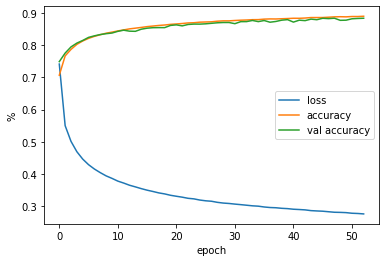

In [8]:
history = model.fit(scaled_train_dt, scaled_train_lb, batch_size=1024, epochs=100, validation_split=0.1, callbacks=[stop])

plot_graph(history)

In [9]:
y_pred = model.predict(scaled_test_dt)

# Convert the pred to discrete values
y_pred = np.argmax(y_pred, axis=1)
class_names = ['Spruce/Fir', 'Lodgepole Pine',
                'Ponderosa Pine', 'Cottonwood/Willow',
                'Aspen', 'Douglas-fir', 'Krummholz']
print(classification_report(scaled_test_lb, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

       Spruce/Fir       0.90      0.87      0.88     42228
   Lodgepole Pine       0.89      0.92      0.90     56749
   Ponderosa Pine       0.83      0.91      0.87      7216
Cottonwood/Willow       0.83      0.76      0.79       544
            Aspen       0.74      0.63      0.69      1816
      Douglas-fir       0.82      0.66      0.73      3574
        Krummholz       0.92      0.89      0.91      4076

         accuracy                           0.89    116203
        macro avg       0.85      0.81      0.83    116203
     weighted avg       0.89      0.89      0.88    116203

